In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib
import plotly.express as px
from matplotlib import pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

In [2]:
# Spokane coordinates: 47.6748 N, 117.3698 W
spokane = 'NASA/POWER_Point_Monthly_Timeseries_1981_2020_047d6748N_117d3698W_LST.json'
df1 = gpd.read_file(spokane)
dict1 = df1['parameter'][0]
Idf1 =  pd.DataFrame.from_dict(dict1)
allsky = pd.DataFrame(Idf1['ALLSKY_KT'])
#allsky
Idf1

,ALLSKY_KT,CLOUD_AMT,CLRSKY_KT,TOA_SW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB,ALLSKY_SRF_ALB,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_PAR_TOT,ALLSKY_SFC_SW_DIFF,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX
198401,0.49,70.70,0.71,2.96,-999.00,-999.00,0.28,-999.00,1.47,2.10,-999.00,-999.00,-999.00,-999
198402,0.51,68.62,0.72,4.52,-999.00,-999.00,0.29,-999.00,2.28,3.26,-999.00,-999.00,-999.00,-999
198403,0.52,72.22,0.76,6.77,-999.00,-999.00,0.28,-999.00,3.52,5.12,-999.00,-999.00,-999.00,-999
198404,0.53,75.34,0.77,9.07,-999.00,-999.00,0.19,-999.00,4.78,6.99,-999.00,-999.00,-999.00,-999
198405,0.51,78.25,0.77,10.79,-999.00,-999.00,0.17,-999.00,5.48,8.24,-999.00,-999.00,-999.00,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202009,0.56,45.03,0.65,7.46,9.27,0.19,0.13,5.44,4.17,4.82,75.07,1.41,86.34,-999
202010,0.52,57.19,0.70,5.16,6.04,0.10,0.16,4.03,2.71,3.60,48.59,1.09,65.12,-999
202011,0.38,76.91,0.70,3.34,2.84,0.03,0.13,2.03,1.24,2.31,22.24,0.63,41.19,-999
202012,0.37,74.83,0.67,2.54,2.08,0.02,0.15,1.92,0.94,1.71,16.65,0.48,30.00,-999


In [9]:
# Removing the annual average from the dataframe

allsky = allsky.drop(allsky.index[12::13])

In [11]:
# Renaming the y axis

allsky = allsky.rename(columns={"ALLSKY_KT": "Solar Ratio"})

In [34]:
# Getting time stamp for each data point

def append(dfseries):
    dfseries = dfseries[:4] + '-' + dfseries[4:]
    return dfseries

# Creating a column with the time data

allsky['Date'] = allsky.index 
allsky['Date'] = allsky['Date'].apply(append)

# Creating a column called 'Year'
# Use this column for Plotly

allsky['Year'] = allsky.index
allsky['Year'] = pd.to_datetime(allsky['Date'])
allsky

(444, 3)


,Solar Ratio,Year,Date
198401,0.49,1984-01-01,1984-01
198402,0.51,1984-02-01,1984-02
198403,0.52,1984-03-01,1984-03
198404,0.53,1984-04-01,1984-04
198405,0.51,1984-05-01,1984-05
...,...,...,...
202008,0.66,2020-08-01,2020-08
202009,0.56,2020-09-01,2020-09
202010,0.52,2020-10-01,2020-10
202011,0.38,2020-11-01,2020-11


## ARIMA

In [46]:
model = ARIMA(allsky['Solar Ratio'].values, order=(1,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()

pred_sol1 = model_fit.predict(start = 0, end = 600)

In [77]:
import datetime

# Converting the data prediction from ARIMA into a dataframe

df = pd.DataFrame()
df['Solar Ratio'] = pred_sol1

# Associating a year and a month with the ARIMA predictions
# Used the 'Year' from the previous data frame and added the additional years predicted by ARIMA 

years = allsky['Year'].tolist()
year = 2021
month = 1
day = 1
for x in range(157):
    if month == 12:
        year += 1 
        month = 1
    years.append(datetime.date(year, month, day))
    month += 1

# Adding the time column 'Years' to the ARIMA dataframe 

df['Year'] = years
df.drop([0], axis=0, inplace=True)
df

,Solar Ratio,Year
1,0.490000,1984-02-01
2,0.510000,1984-03-01
3,0.520000,1984-04-01
4,0.530000,1984-05-01
5,0.510000,1984-06-01
...,...,...
596,0.597644,2034-10-01
597,0.537509,2034-11-01
598,0.428520,2035-01-01
599,0.375433,2035-02-01


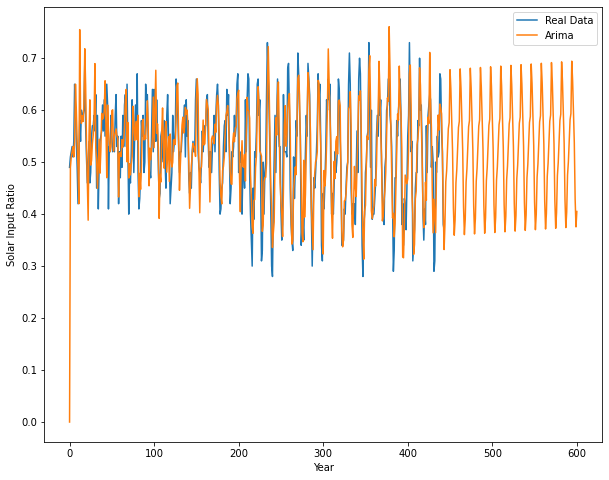

In [48]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(allsky['Solar Ratio'].values,label = 'Real Data')
ax.plot(pred_sol1, label = 'Arima')
ax.set_xlabel('Year')
ax.set_ylabel('Solar Input Ratio')
ax.legend()

## Plotly

Plotly needs an x and a y argument, therefore I'm having trouble with basic plots because of the way the data is formatted.

In [80]:
#fig = px.scatter(allsky, x = "Year", y = "Solar Ratio", trendline="ols",  trendline_scope="overall") 
fig = px.scatter(df, x = 'Year', y = 'Solar Ratio', trendline="ols",  trendline_scope="overall")
#px.plot(pred_sol1, label = 'arima', trendline="ols")
fig.show()

There are some plots in Plotly that require access tokens. I'm not sure how to import an access token into python but there is still a lot of good graphs that can be used without the access token. 

In [61]:
#import mapbox
#from mapbox import Geocoder
#geocoder = Geocoder(access_token="pk.eyJ1IjoiaXBhY2giLCJhIjoiY2wwZnAxbzE4MHYwMzNib2R2cGtoYm9wYiJ9.glp4AyHutsNt476pL95ehQ")
#px.set_mapbox_access_token(open(".mapbox_token").read())

Here I created a csv file with the latitude and longitude coordinates as well as the corresponding city or near by town. 

In [7]:
locations = pd.read_csv('Locations.csv')
locations.head()

,lat,lon,Place
0,49.0362,-122.3247,"Abbotsford, Canada"
1,49.0362,-118.4245,"Grand Forks, Canada"
2,48.9289,-117.8306,"Northport, WA"
3,48.7835,-122.3357,"Dewey, WA"
4,48.7826,-121.7994,"Mt. Baker, WA"


## Maps

First map example using Plotly. It only has the coordinates and location. Here I was beginning to get familiar with Plotly. This may be the best map because it already focuses on the PNW. 

In [8]:
fig = px.scatter_mapbox(locations, lat="lat", lon="lon", hover_name = "Place", 
                        color_discrete_sequence=["darkviolet"], zoom=5.5, height=400, width = 600)
# styles: "open-street-map" or "carto-positron" are the best options 
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Here is another map through geopandas. There isn't any data associated with each location yet, which I think is the reason why the points aren't visible on the map yet. Also, I'm not sure how to focus on only the PNW. This one may be useful though because it automatically labels them with a color.

In [5]:
fig = px.scatter_geo(locations, lat="lat", lon="lon", locations="Place", 
                     color="Place", hover_name="Place", scope="usa")
#fig.update_geos(fitbounds="locations")
fig.show()

Using a different plot type from Plotly

In [6]:
import plotly.graph_objects as go

In [7]:
fig = go.Figure(data=go.Scattergeo(
        lon = locations['lon'],
        lat = locations['lat'],
        text = locations['Place'],
        mode = 'markers',
        #marker_color = df['cnt'],
        ))

fig.update_layout(title = 'Locations for Solar Forecasting', geo_scope='usa')
fig.show()